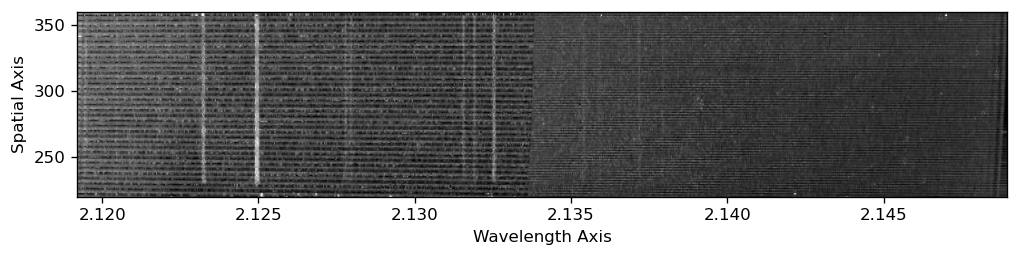

In [2]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from lmfit import Model
from lmfit.models import PolynomialModel, QuadraticModel, LinearModel, ConstantModel
from lmfit import minimize, Parameters, fit_report

import os
import warnings
warnings.filterwarnings('ignore')


# path joining version for other paths
notebook_path = os.path.abspath('/Users/RuoyanWang/Documents/LEICESTER/h3p/code/')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

# define object and sky frame
fn_spec = 65 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
target_spec = nirspec7_data_array[fn_spec-start_nirspec7]
sky_subtracted = (target_spec - sky_total) / (average_flat_field - average_flat_lamp_off)
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
#plt.figure(figsize=(12,6))
#plt.imshow(sky_subtracted, cmap='gist_gray')
#plt.xlabel('Wavelength Axis')
#plt.ylabel('Spatial Axis')
#plt.gca().invert_yaxis()
#plt.xlim(50,150)
#plt.ylim(40,130)
#plt.colorbar(orientation='horizontal', pad=0.1)


# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# load skylines
# skylines = fits.open(filepath + 'skyandarc2.fits', ignore_missing_end=True)[0].data
skylines = fits.open(filepath + 'order36/skylines_shifted_order36.fits', ignore_missing_end=True)[0].data

plt.figure(figsize=(10,2))
plt.imshow(skylines, aspect='auto', extent=[waverange[0], waverange[-1], 360, 220], cmap='gist_gray')
# plt.imshow(skylines, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()

In [4]:
gemini_df = pd.read_csv('mk_skybg_zm_10_10_ph.dat', sep='\s+', header=None)
gemini_array = gemini_df.to_numpy()

wavelength = (gemini_array[60500:62500,0]/1000)#[gemini_array[60500:62500,1]>0.5]
count = gemini_array[60500:62500,1]#[gemini_array[60500:62500,1]>0.5]

# plt.plot(wavelength, count, 'k')
#plt.xlim(min(wavelength), max(wavelength))
#plt.xlim(2.11,2.15)
#plt.xlim(2.132,2.133)
#plt.ylim(min(count), 800)

# create lmfit model with defined gaussian
g1_model = Model(gaussian_fit)

# create parameters and add initial guess
g1_params = g1_model.make_params()
g1_params.add('a0', value=290)
g1_params.add('a1', value=2.12325)
g1_params.add('a2', value=0.003)
g1_params.add('a3', value=0)
g1_params.add('a4', value=0)
g1_params.add('a5', value=0)

try:
    g1_result = g1_model.fit(count, g1_params, x=wavelength)
except:
    pass

#print(g1_result.fit_report())

# plt.figure()
# plt.plot(wavelength, count, 'k', label='original')
# plt.plot(wavelength, g1_result.best_fit, 'r--', label='best fit')
# plt.legend()
# plt.xlim(2.123,2.1235)

print(g1_result.params['a1'].value)

# create lmfit model with defined gaussian
g2_model = Model(gaussian_fit)
#print('parameter names: {}'.format(g2model.param_names))
#print('independent variables: {}'.format(g2model.independent_vars))


# create parameters and add initial guess
g2_params = g2_model.make_params()
g2_params.add('a0', value=692)
g2_params.add('a1', value=2.125)
g2_params.add('a2', value=0.004)
g2_params.add('a3', value=0)
g2_params.add('a4', value=0)
g2_params.add('a5', value=0)

try:
    g2_result = g2_model.fit(count, g2_params, x=wavelength)
except:
    pass

#print(g2_result.fit_report())

#plt.figure()
# plt.plot(wavelength, count, 'k', label='original')
# plt.plot(wavelength, g2_result.best_fit, 'r--', label='best fit')
#plt.legend()
#plt.xlim(2.1246,2.1252)

print(g2_result.params['a1'].value)

# create lmfit model with defined gaussian
g3_model = Model(gaussian_fit)

# create parameters and add initial guess
g3_params = g3_model.make_params()
g3_params.add('a0', value=290)
g3_params.add('a1', value=2.1326)
g3_params.add('a2', value=0.003)
g3_params.add('a3', value=0)
g3_params.add('a4', value=0)
g3_params.add('a5', value=0)

try:
    g3_result = g3_model.fit(count, g3_params, x=wavelength)
except:
    pass

#print(g3_result.fit_report())

#plt.figure()
# plt.plot(wavelength, count, 'k', label='original')
# plt.plot(wavelength, g3_result.best_fit, 'r--', label='best fit')
#plt.legend()
#plt.xlim(2.1315,2.133)

print(g3_result.params['a1'].value)

2.1232420081711174
2.124959996615822
2.1325969957673254


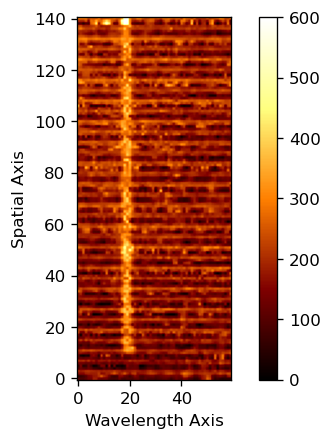

In [5]:
a = np.delete(skylines, np.s_[180:], 1)
b = np.delete(a, np.s_[:120], 1)

plt.figure()
# plt.imshow(c, aspect='auto', extent=[waverange[120], waverange[179], 364, 225], cmap='afmhot')
plt.imshow(b, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()

Error occured at i=116


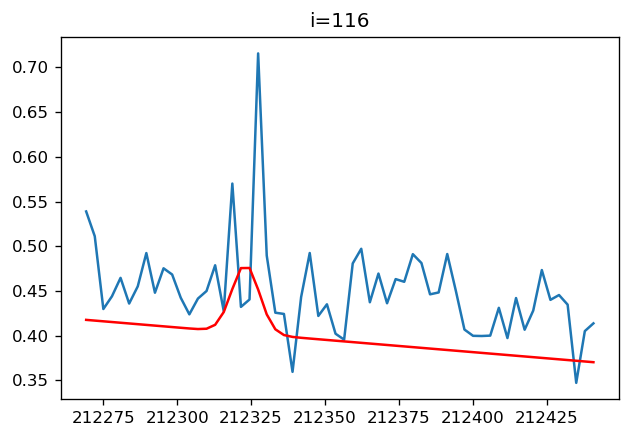

In [6]:
a = np.delete(skylines, np.s_[180:], 1)
b = np.delete(a, np.s_[:120], 1)
b = normalize(b)
waveaxis = waverange[120:180]*100000

upper_skyline = 141
lower_skyline = 10

sky1_wave = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=212324, min=212315)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_wave[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_wave = sky1_wave/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 131
    # variables        = 1
    chi-square         = 3.3008e-08
    reduced chi-square = 2.5391e-10
    Akaike info crit   = -2893.32564
    Bayesian info crit = -2890.45044
[[Variables]]
    c:  2.12323564 +/- 1.3922e-06 (0.00%) (init = 2.123236)


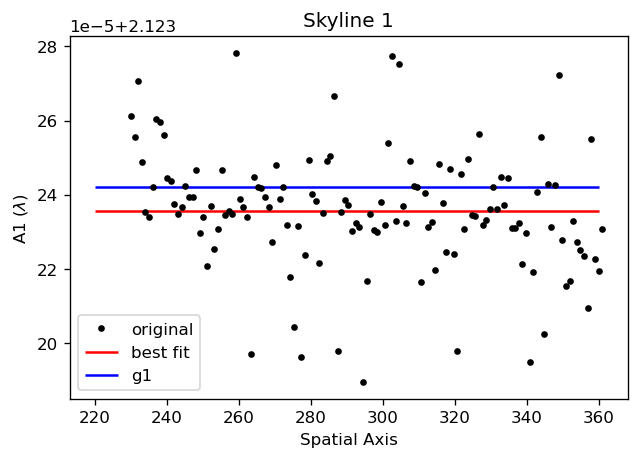

In [7]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_wave))+220

x = sky1_spat
y = sky1_wave

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(220, 360, 141)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_wave_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_wave_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 ($\lambda$)')
plt.legend()

Error occured at i=116
Error occured at i=118
Error occured at i=121
Error occured at i=123
Error occured at i=124


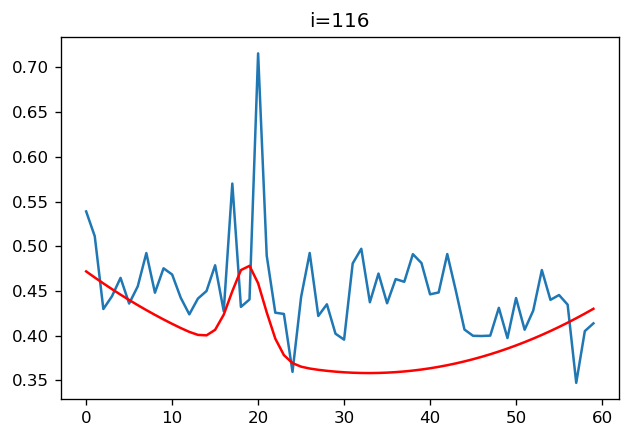

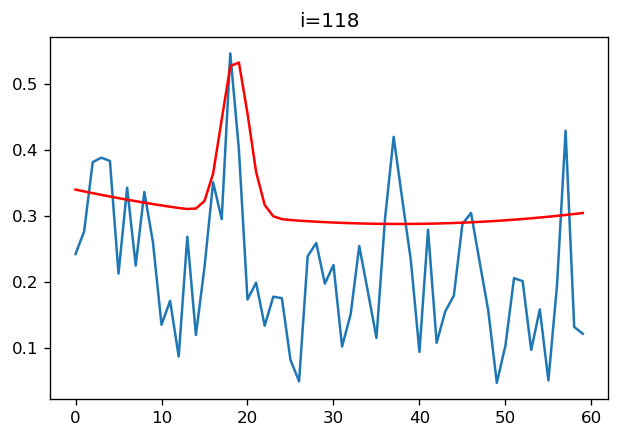

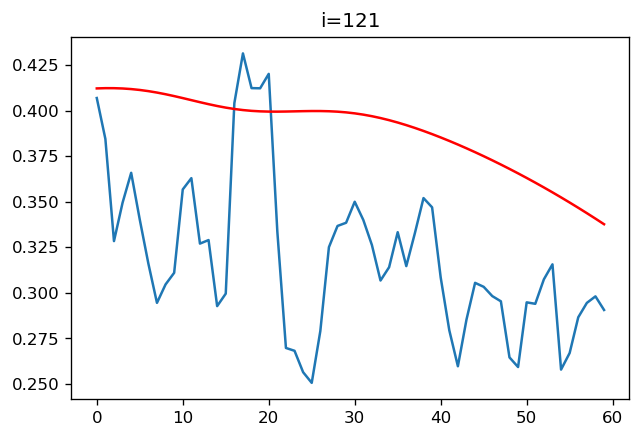

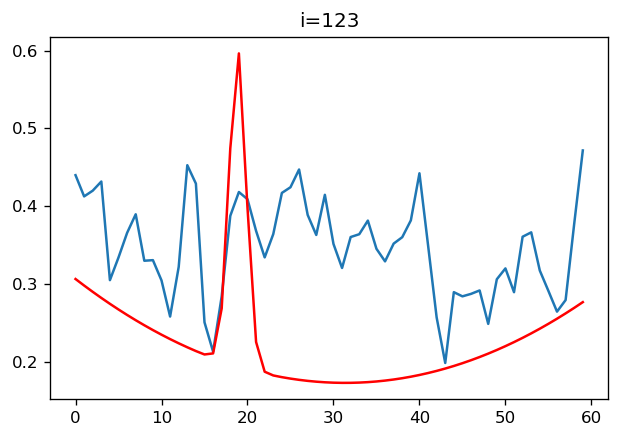

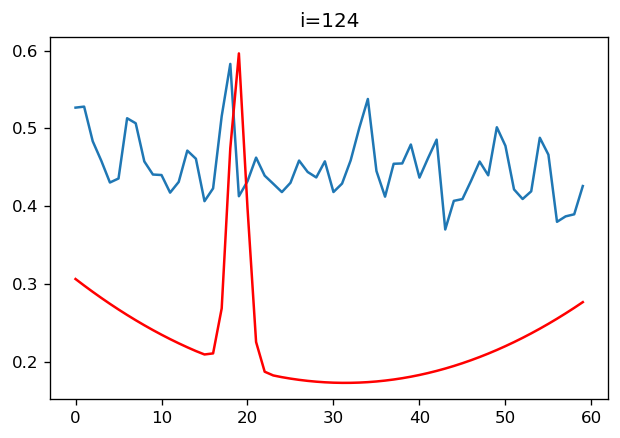

In [8]:
a = np.delete(skylines, np.s_[180:], 1)
b = np.delete(a, np.s_[:120], 1)
b = normalize(b)
# waveaxis = waverange[120:180]*100000
waveaxis = np.linspace(0 ,np.size(b,1)-1, np.size(b,1))

upper_skyline = 141
lower_skyline = 10

sky1_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky1_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky1_params = sky1_model.make_params()
        sky1_params.add('a0', value=0.7)
        sky1_params.add('a1', value=19, min=17, max=21)
        sky1_params.add('a2', value=3)
        sky1_params.add('a3', value=0.3)
        sky1_params.add('a4', value=0)
        sky1_params.add('a5', value=0)
    
        try:
            sky1_fit_result = sky1_model.fit(b[i], sky1_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky1_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, b[i])
            plt.plot(waveaxis, sky1_fit_result.best_fit, 'r-', label='best fit')
            
        sky1_a1[i-lower_skyline] = sky1_fit_result.params['a1'].value
sky1_a1 = sky1_a1+120

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 131
    # variables        = 1
    chi-square         = 43.1488266
    reduced chi-square = 0.33191405
    Akaike info crit   = -143.481015
    Bayesian info crit = -140.605818
[[Variables]]
    c:  138.683697 +/- 0.05033582 (0.04%) (init = 138.6837)


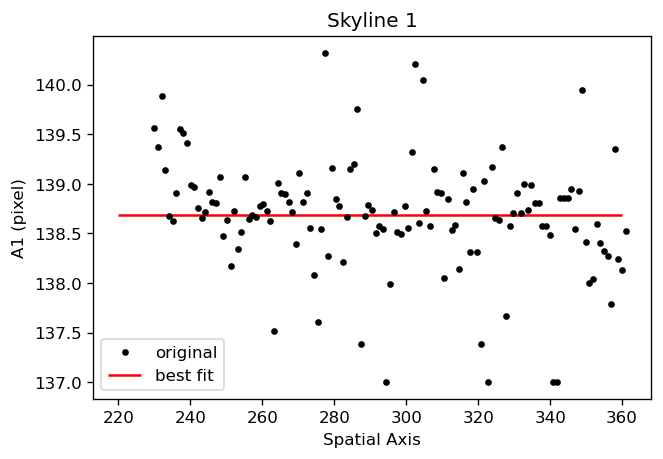

In [9]:
sky1_spat = np.linspace(lower_skyline, upper_skyline, len(sky1_wave))+220

x = sky1_spat
y = sky1_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky1_spat_all = np.linspace(220, 360, 141)
# sky1_slope = out.params['slope'].value
# sky1_intercept = out.params['intercept'].value
sky1_c = out.params['c'].value
sky1_a1_best_fit = sky1_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky1_a1_best_fit, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='r', label='best fit')
# plt.hlines(g1_result.params['a1'].value, xmin=sky1_spat_all[0], xmax=sky1_spat_all[-1], color='b', label='g1')
plt.title('Skyline 1')
plt.xlabel('Spatial Axis')
plt.ylabel('A1 (pixel)')
plt.legend()

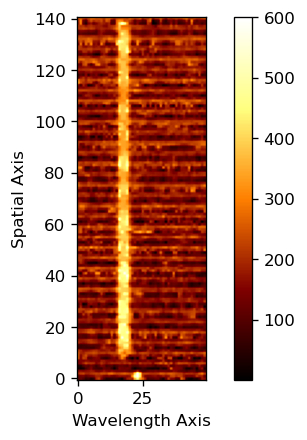

In [10]:
c = np.delete(skylines, np.s_[230:], 1)
d = np.delete(c, np.s_[:180], 1)

plt.figure()
plt.imshow(d, cmap='afmhot')
# plt.imshow(d, aspect='auto', extent=[waverange[120], waverange[209], 364, 225], cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
plt.colorbar()
# plt.ylim(0,10)

In [11]:
c = np.delete(skylines, np.s_[230:], 1)
d = np.delete(c, np.s_[:180], 1)
d = normalize(d)
waveaxis = waverange[180:230]*100000

upper_skyline = 141
lower_skyline = 10

sky2_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):          
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky2_params = sky2_model.make_params()
        sky2_params.add('a0', value=0.6)
        sky2_params.add('a1', value=212496)
        sky2_params.add('a2', value=2)
        sky2_params.add('a3', value=0.3)
        sky2_params.add('a4', value=0)
        sky2_params.add('a5', value=0)
    
        try:
            sky2_fit_result = sky2_model.fit(d[i], sky2_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky2_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, d[i])
            plt.plot(waveaxis, sky2_fit_result.best_fit, 'r-', label='best fit')
            
        sky2_a1[i-lower_skyline] = sky2_fit_result.params['a1'].value
sky2_a1 = sky2_a1/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 131
    # variables        = 1
    chi-square         = 1.5797e-08
    reduced chi-square = 1.2152e-10
    Akaike info crit   = -2989.86237
    Bayesian info crit = -2986.98717
[[Variables]]
    c:  2.12494973 +/- 9.6312e-07 (0.00%) (init = 2.12495)


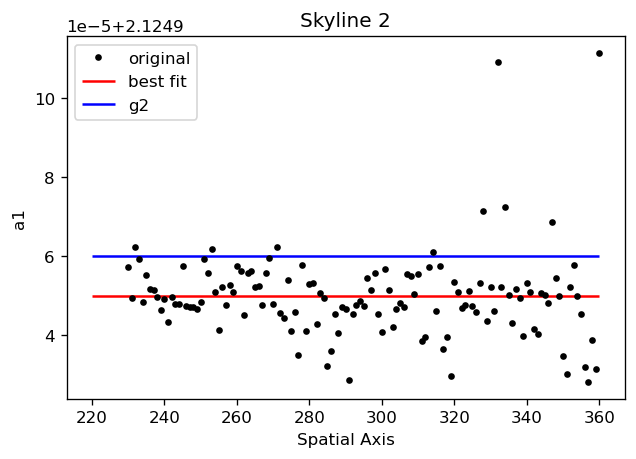

In [12]:
sky2_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky2_a1))+220

x = sky2_spat
y = sky2_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky2_spat_all = np.linspace(220, 360, 141)
sky2_c = out.params['c'].value
sky2_a1_best_fit = sky2_c


plt.figure()
plt.plot(sky2_spat, sky2_a1,'.k', label = 'original')
plt.hlines(sky2_a1_best_fit, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='r', label='best fit')
plt.hlines(g2_result.params['a1'].value, xmin=sky2_spat_all[0], xmax=sky2_spat_all[-1], color='b', label='g2')
plt.title('Skyline 2')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
# plt.ticklabel_format(useOffset=False)
plt.legend()

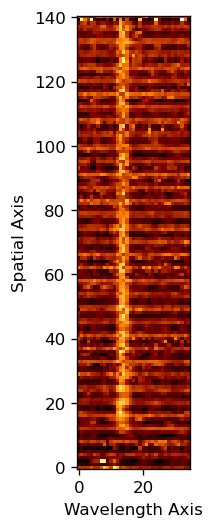

In [13]:
e = np.delete(skylines, np.s_[480:], 1)
f = np.delete(e, np.s_[:445], 1)

plt.figure(figsize=(2,5))
# plt.imshow(g, aspect='auto', extent=[waverange[445], waverange[480], 364, 225], cmap='afmhot')
plt.imshow(f, cmap='afmhot')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.ticklabel_format(useOffset=False)
plt.gca().invert_yaxis()

Error occured at i=66
Error occured at i=83
Error occured at i=87
Error occured at i=99
Error occured at i=116
Error occured at i=139


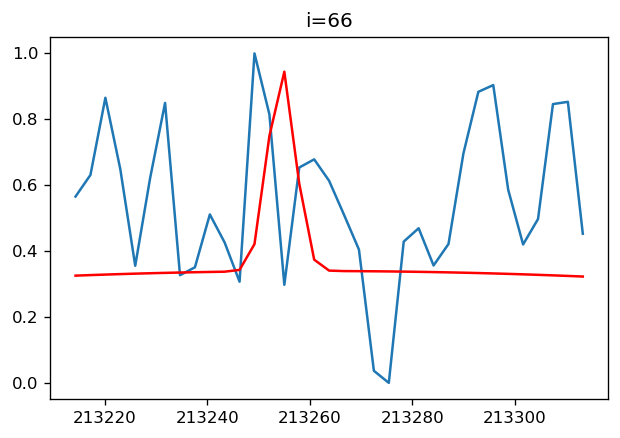

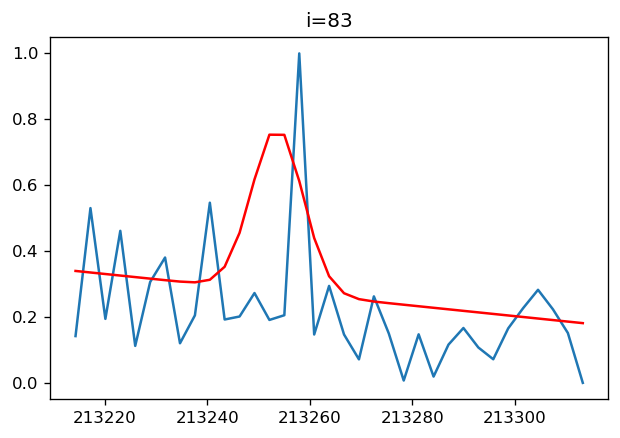

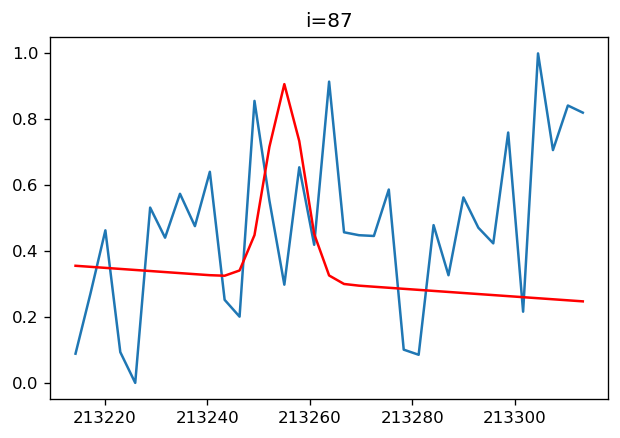

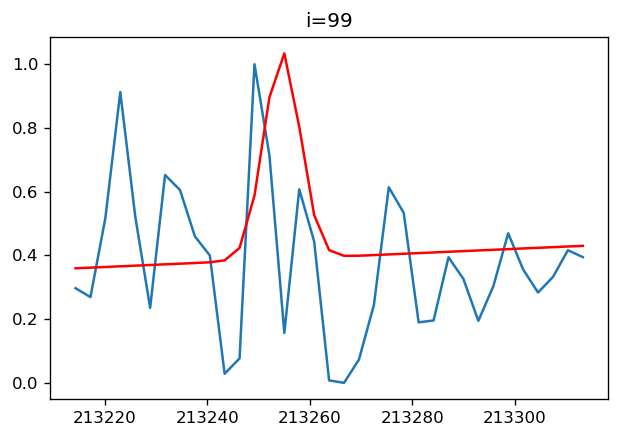

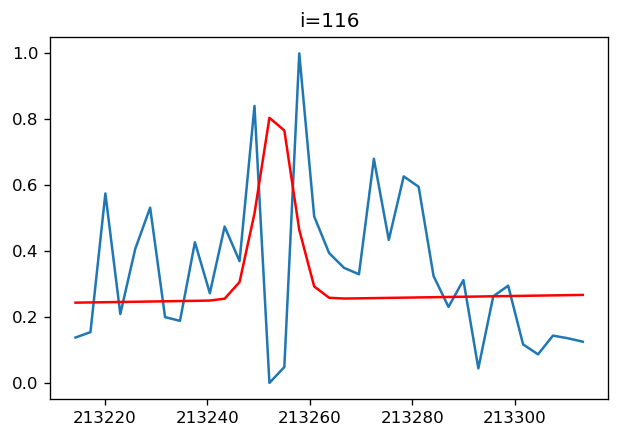

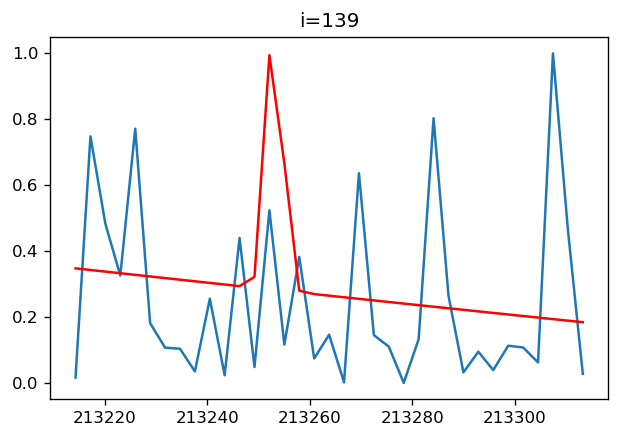

In [14]:
e = np.delete(skylines, np.s_[480:], 1)
f = np.delete(e, np.s_[:445], 1)
f = normalize(f)
waveaxis = waverange[445:480]*100000

upper_skyline = 141
lower_skyline = 10

sky3_wave = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):            
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.7)
        sky3_params.add('a1', value=213256, min=213247, max=213262)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(f[i]), sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, normalize(f[i]))
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_wave[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_wave = sky3_wave/100000

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 131
    # variables        = 1
    chi-square         = 4.9692e-08
    reduced chi-square = 3.8224e-10
    Akaike info crit   = -2839.73397
    Bayesian info crit = -2836.85877
[[Variables]]
    c:  2.13254179 +/- 1.7082e-06 (0.00%) (init = 2.132542)


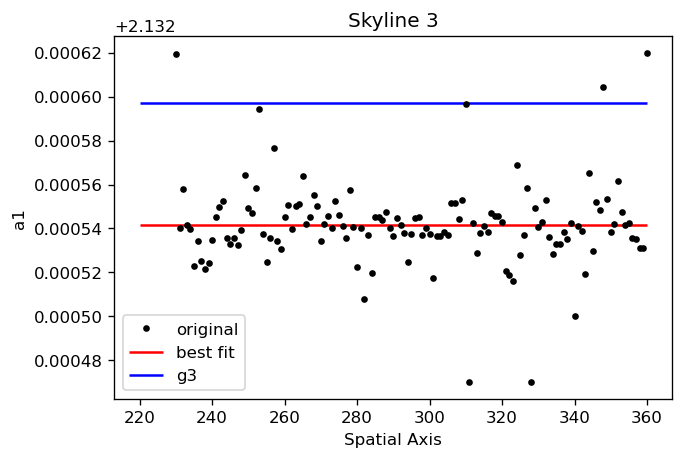

In [15]:
sky3_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky3_wave))+220

x = sky3_spat
y = sky3_wave

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(220, 360, 141)
sky3_c = out.params['c'].value
sky3_wave_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_wave_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend(loc='lower left')

Error occured at i=33
Error occured at i=89
Error occured at i=117
Error occured at i=120
Error occured at i=140


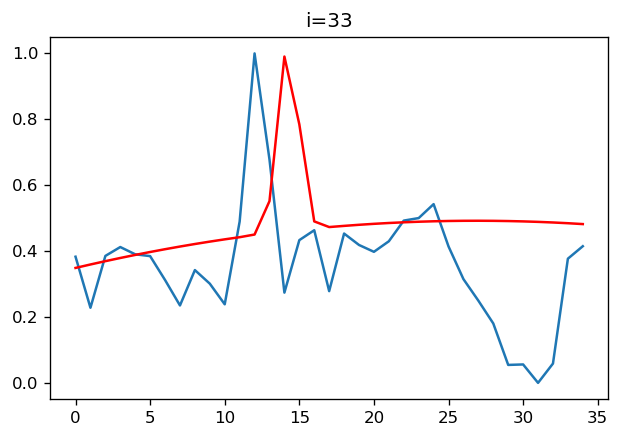

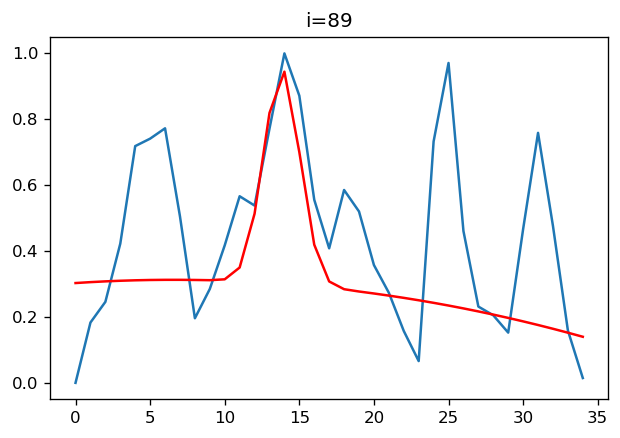

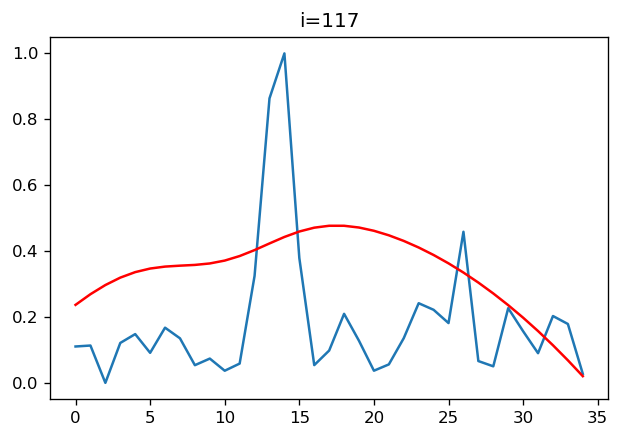

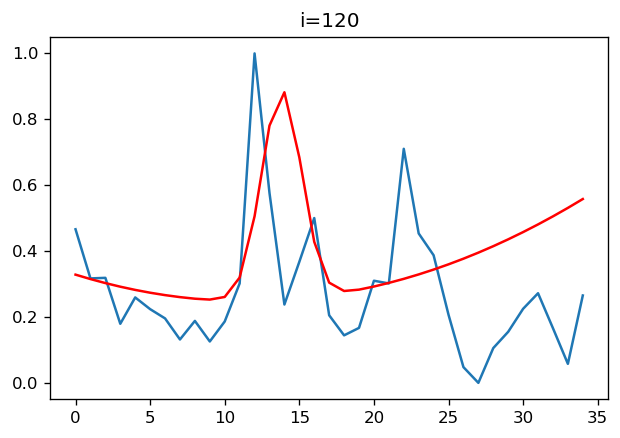

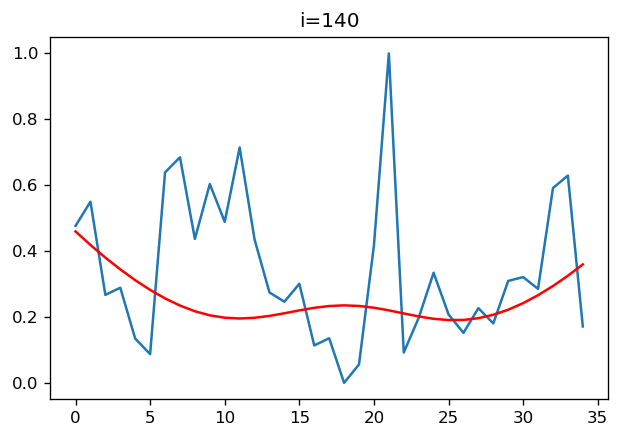

In [16]:
e = np.delete(skylines, np.s_[480:], 1)
f = np.delete(e, np.s_[:445], 1)
f = normalize(f)
# waveaxis = waverange[445:480]*100000
waveaxis = np.linspace(0 ,np.size(f,1)-1, np.size(f,1))

upper_skyline = 141
lower_skyline = 10

sky3_a1 = np.zeros(upper_skyline - lower_skyline)

for i in range(lower_skyline, upper_skyline):            
    if i >= lower_skyline and i < upper_skyline:
        # create lmfit model with defined gaussian
        sky3_model = Model(gaussian_fit)

        # create parameters and add initial guess
        sky3_params = sky3_model.make_params()
        sky3_params.add('a0', value=0.7)
        sky3_params.add('a1', value=13, min=10)
        sky3_params.add('a2', value=3)
        sky3_params.add('a3', value=0.2)
        sky3_params.add('a4', value=0)
        sky3_params.add('a5', value=0)
    
        try:
            sky3_fit_result = sky3_model.fit(normalize(f[i]), sky3_params, x=waveaxis)
        except:
            print('Error occured at i=' + str(i))
            #print(sky3_fit_result.fit_report())
            plt.figure()
            plt.title('i='+str(i))
            plt.plot(waveaxis, normalize(f[i]))
            plt.plot(waveaxis, sky3_fit_result.best_fit, 'r-', label='best fit')
        
        sky3_a1[i-lower_skyline] = sky3_fit_result.params['a1'].value
        
sky3_a1 = sky3_a1+445

[[Model]]
    Model(constant)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 2
    # data points      = 131
    # variables        = 1
    chi-square         = 421.554419
    reduced chi-square = 3.24272630
    Akaike info crit   = 155.106453
    Bayesian info crit = 157.981651
[[Variables]]
    c:  458.795722 +/- 0.15733288 (0.03%) (init = 458.7957)


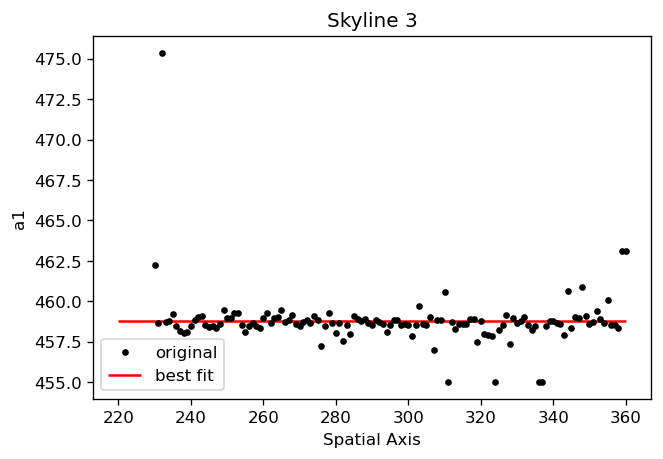

In [17]:
sky3_spat = np.linspace(lower_skyline, upper_skyline-1, len(sky3_a1))+220

x = sky3_spat
y = sky3_a1

mod = ConstantModel()

pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)

print(out.fit_report(min_correl=0.25))

sky3_spat_all = np.linspace(220, 360, 141)
sky3_c = out.params['c'].value
sky3_a1_best_fit = sky3_c

plt.plot(x, y, '.k', label = 'original')
plt.hlines(sky3_a1_best_fit, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='r', label='best fit')
# plt.hlines(g3_result.params['a1'].value, xmin=sky3_spat_all[0], xmax=sky3_spat_all[-1], color='b', label='g3')
plt.title('Skyline 3')
plt.xlabel('Spatial Axis')
plt.ylabel('a1')
plt.legend(loc='lower left')

In [25]:
print(sky1_wave_best_fit)
print(sky3_wave_best_fit)
print(sky1_a1_best_fit)
print(sky3_a1_best_fit)

R = (sky1_wave_best_fit + sky3_wave_best_fit)*0.5/((sky3_wave_best_fit - sky1_wave_best_fit)/(sky3_a1_best_fit - sky1_a1_best_fit))
# np.savetxt('resolution.txt', R)
R

2.1232356350601456
2.1325417922503336
138.68369678722655
458.7957224173291


73194.84858495607

In [19]:
((sky3_wave_best_fit - sky1_wave_best_fit)/(sky3_a1_best_fit - sky1_a1_best_fit))

2.9071563843532424e-05

In [20]:
waverange

array([2.1192026, 2.1192317, 2.1192608, ..., 2.1488934, 2.1489224,
       2.1489515], dtype=float32)

In [21]:
R.shape

(1024,)